In [1]:
pip install mahotas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import libraries
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
from skimage.feature import canny
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects
from skimage.metrics import structural_similarity as ssim
from skimage.morphology import dilation, disk

Sigma: 4
Block Size: 1000
Precision: 0.5566
Recall: 1.0000
F1-Measure: 0.7152


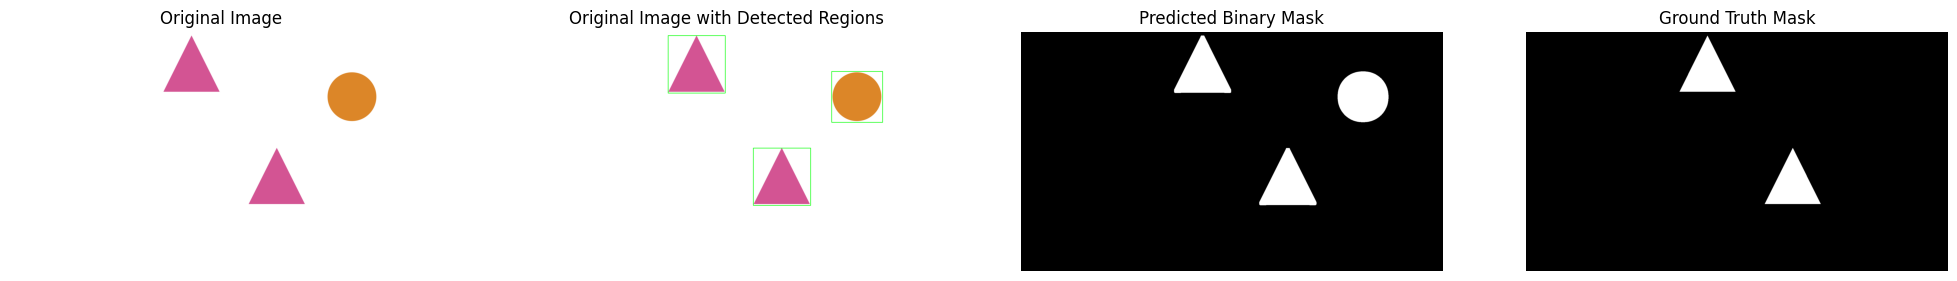

In [910]:

# Function to compute Zernike Moments
def compute_hu_moments(image):
    moments = cv2.HuMoments(cv2.moments(image)).flatten()
    return moments  # Trả về tất cả 7 Hu Moments

# Load image
image_path = '13.png'  # Đường dẫn ảnh gốc
ground_truth_path = '12.png'  # Đường dẫn truth mask (require: trắng đen)

# Chỉnh sửa các thông số ở dưới

# Parameters for block size and degree
block_size = 1000  # Giá trị nhỏ hơn: Giữ lại cả các vùng nhỏ hơn, có thể dẫn đến nhiều nhiễu. Giá trị lớn hơn: Loại bỏ nhiều vùng nhỏ, chỉ giữ lại các vùng lớn hơn (như các con chim trong hình).
thrshold_value_pow = -4 # ngưỡng so sánh, càng nhỏ thì càng chi tiết hơn, tránh so sánh nhầm các chi tiết ko thực sự giống nhau, nhưng nếu nhỏ quá thì sẽ bỏ qua nhiều chi tiết
threshold = math.pow(10, thrshold_value_pow)
sigma = 4 # mức độ làm mờ (blur) khi áp dụng bộ lọc Gaussian
iterations = 4 # số lần lặp lại (iterations) của một thuật toán dãn nở
kernel_size = 10 # Nếu kernel_size nhỏ, bộ lọc tập trung vào các chi tiết cục bộ. Nếu kernel_size lớn, bộ lọc xử lý trên phạm vi rộng 






image = cv2.imread(image_path)
ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)  # Load ground truth as grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


# Resize ground truth to match input image size if necessary
if ground_truth.shape != gray_image.shape:
    ground_truth = cv2.resize(ground_truth, (gray_image.shape[1], gray_image.shape[0]), interpolation=cv2.INTER_NEAREST)

# Ensure ground truth is binary
ground_truth = (ground_truth > 128).astype(np.uint8) * 255

# Phát hiện cạnh và áp dụng phép dãn nở để nối các viền bị đứt
edges = canny(gray_image, sigma)
edges = (edges * 255).astype(np.uint8)  # Convert edges to uint8 for OpenCV processing
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))  # Adjust kernel size as needed
dilated_edges = cv2.dilate(edges, kernel, iterations)
labeled_image = label(dilated_edges)
regions = regionprops(labeled_image)


# Tính toán các moments Zernike cho mỗi vùng phát hiện được
moments_list = []
for region in regions:
    if region.area > block_size:  # Bỏ qua các vùng nhỏ dựa trên kích thước block
        min_row, min_col, max_row, max_col = region.bbox
        region_crop = gray_image[min_row:max_row, min_col:max_col]
        region_moments = compute_hu_moments(region_crop)
        moments_list.append((region, region_moments))

# So sánh các vùng để tìm sự tương đồng
similar_regions = []
binary_mask = np.zeros(gray_image.shape, dtype=np.uint8)  # Mặt nạ nhị phân để hiển thị

for i in range(len(moments_list)):
    for j in range(i + 1, len(moments_list)):
        similarity = np.linalg.norm(moments_list[i][1] - moments_list[j][1])
        if similarity < 0.1:  # Ngưỡng cho sự tương đồng
            similar_regions.append((moments_list[i][0], moments_list[j][0]))

# Đánh dấu các vùng tương đồng trong mặt nạ nhị phân và tô đầy trực tiếp
binary_mask = np.zeros(gray_image.shape, dtype=np.uint8)  # Mặt nạ nhị phân để hiển thị
output_image = image.copy()

# Mark similar regions in binary mask and draw rectangles on the output image
output1_image = image.copy()
for region_pair in similar_regions:
    for region in region_pair:
        min_row, min_col, max_row, max_col = region.bbox
        cv2.rectangle(output1_image, (min_col, min_row), (max_col, max_row), (0, 255, 0), 2)

for region_pair in similar_regions:
    for region in region_pair:
        # Tạo một mặt nạ cho vùng cụ thể
        filled_region_mask = np.zeros_like(gray_image, dtype=np.uint8)

        # Sử dụng region.coords để đánh dấu vùng
        for coord in region.coords:
            filled_region_mask[coord[0], coord[1]] = 255

        # Tô đầy vùng bằng cách sử dụng contours
        contours, _ = cv2.findContours(filled_region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(binary_mask, contours, -1, 255, thickness=cv2.FILLED)  # Tô đầy vùng trong mặt nạ nhị phân
        #cv2.drawContours(output_image, contours, -1, (0, 255, 0), thickness=cv2.FILLED)  # Làm nổi bật vùng trong ảnh output



# Precision, Recall, F1-Measure Calculation
# Binarize predicted mask and ground truth for evaluation
binary_mask = (binary_mask > 0).astype(np.uint8)
ground_truth = (ground_truth > 0).astype(np.uint8)

# Calculate true positives (TP), false positives (FP), and false negatives (FN)
TP = np.sum((binary_mask == 1) & (ground_truth == 1))  # True Positive
FP = np.sum((binary_mask == 1) & (ground_truth == 0))  # False Positive
FN = np.sum((binary_mask == 0) & (ground_truth == 1))  # False Negative

# Compute precision, recall, and F1-measure
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_measure = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Display evaluation results
#print(f"Thrshold value pow: {thrshold_value_pow}")
print(f"Sigma: {sigma}")
#print(f"Iterations: {iterations}")
#print(f"Kernel size: {kernel_size}")
print(f"Block Size: {block_size}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Measure: {f1_measure:.4f}")

# Display the ground truth image alongside the results
plt.figure(figsize=(25, 25))

# Show original image with detected regions
plt.subplot(1, 4, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Original Image with Detected Regions")
plt.imshow(cv2.cvtColor(output1_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Show binary mask of detected regions
plt.subplot(1, 4, 3)
plt.title("Predicted Binary Mask")
plt.imshow(binary_mask, cmap='gray')
plt.axis('off')

# Show ground truth image
plt.subplot(1, 4, 4)
plt.title("Ground Truth Mask")
plt.imshow(ground_truth, cmap='gray')
plt.axis('off')

plt.show()


In [983]:
image_path = '7.JPG' 
ground_truth_path = '7a.JPG'

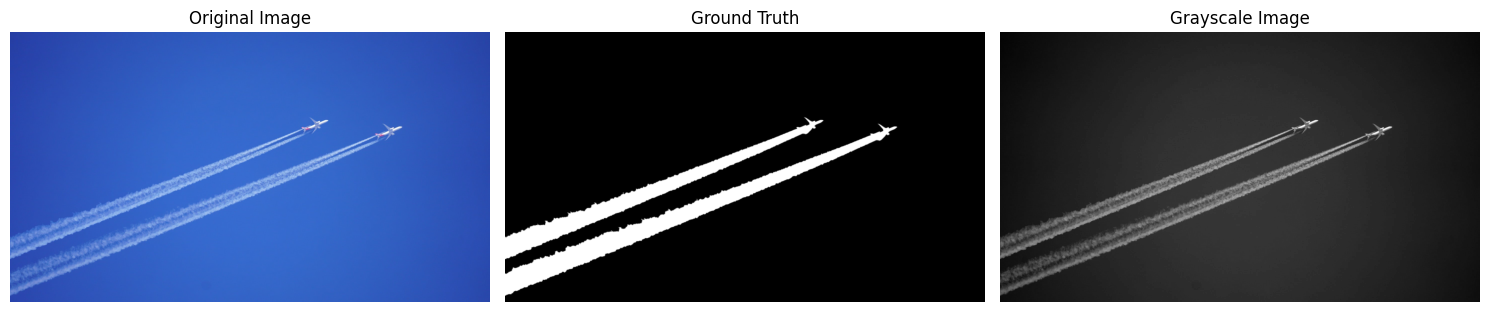

In [984]:
image = cv2.imread(image_path)
ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Chuyển từ BGR sang RGB để hiển thị đúng màu
plt.axis('off')

# Ground Truth
plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(ground_truth, cmap='gray')  # Ground truth ở dạng grayscale
plt.axis('off')

# Ảnh xám
plt.subplot(1, 3, 3)
plt.title("Grayscale Image")
plt.imshow(gray_image, cmap='gray')  # Ảnh xám
plt.axis('off')

plt.tight_layout()
plt.show()

In [985]:
def compute_hu_moments(image):
    moments = cv2.HuMoments(cv2.moments(image)).flatten()
    return moments

In [986]:
if ground_truth.shape != gray_image.shape:
    ground_truth = cv2.resize(ground_truth, (gray_image.shape[1], gray_image.shape[0]), interpolation=cv2.INTER_NEAREST)

ground_truth = (ground_truth > 128).astype(np.uint8) * 255

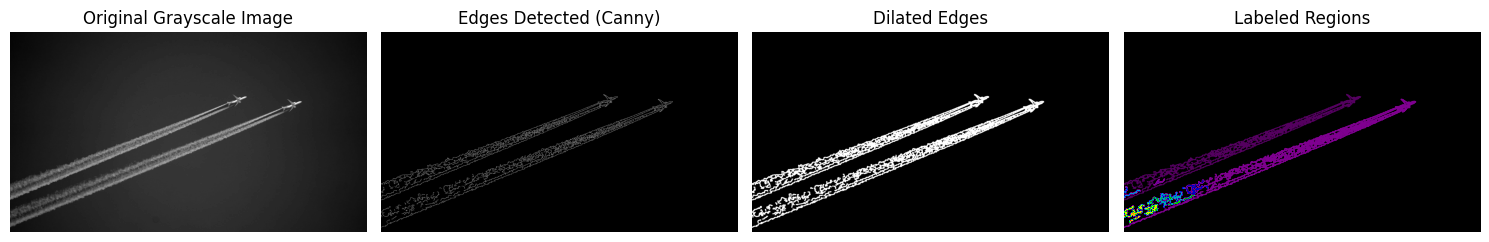

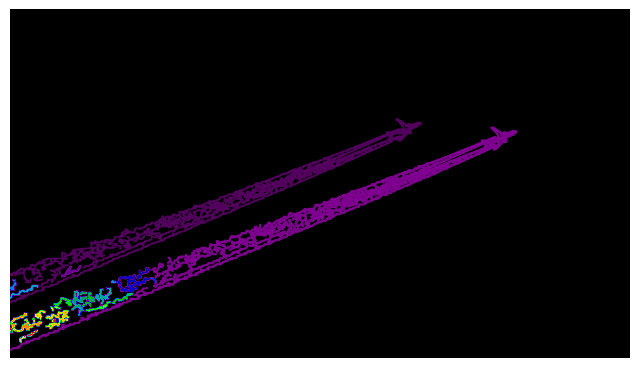

Nhãn vùng: 1
Diện tích: 53704.0
Tâm vùng: (621.8577014747505, 615.3954267838523)
Bounding Box: (338, 0, 910, 1275)
------------END------------
Nhãn vùng: 2
Diện tích: 54422.0
Tâm vùng: (649.7826062989233, 917.3514755062291)
Bounding Box: (364, 0, 1057, 1571)
------------END------------
Nhãn vùng: 3
Diện tích: 717.0
Tâm vùng: (810.836820083682, 188.1199442119944)
Bounding Box: (793, 159, 830, 221)
------------END------------
Nhãn vùng: 4
Diện tích: 582.0
Tâm vùng: (816.5893470790378, 411.0257731958763)
Bounding Box: (799, 392, 836, 434)
------------END------------
Nhãn vùng: 5
Diện tích: 2081.0
Tâm vùng: (848.9346468044209, 373.82364247957713)
Bounding Box: (822, 333, 876, 430)
------------END------------
Nhãn vùng: 6
Diện tích: 179.0
Tâm vùng: (837.3072625698323, 443.9441340782123)
Bounding Box: (831, 431, 849, 453)
------------END------------
Nhãn vùng: 7
Diện tích: 353.0
Tâm vùng: (854.8923512747875, 10.444759206798867)
Bounding Box: (836, 0, 871, 20)
------------END------------
Nhãn

In [987]:
block_size = 500  
sigma = 1
kernel_size = 5

edges = canny(gray_image, sigma)
edges = (edges * 255).astype(np.uint8)  
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
dilated_edges = cv2.dilate(edges, kernel, 1)
labeled_image = label(dilated_edges)

regions = regionprops(labeled_image)



plt.figure(figsize=(15, 5))
    
# Ảnh gốc xám
plt.subplot(1, 4, 1)
plt.title("Original Grayscale Image")
plt.imshow(gray_image, cmap='gray')
plt.axis('off')

# Ảnh cạnh (Edges)
plt.subplot(1, 4, 2)
plt.title("Edges Detected (Canny)")
plt.imshow(edges, cmap='gray')
plt.axis('off')

# Ảnh giãn nở cạnh (Dilated Edges)
plt.subplot(1, 4, 3)
plt.title("Dilated Edges")
plt.imshow(dilated_edges, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("Labeled Regions")
plt.imshow(labeled_image, cmap='nipy_spectral')  # Colormap để dễ phân biệt các nhãn
# plt.colorbar(label="Region Labels")  # Thêm thanh màu thể hiện các nhãn
plt.axis('off')

# Hiển thị tất cả
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(labeled_image, cmap='nipy_spectral')
plt.axis('off')
plt.show()

for region in regions:
    print("Nhãn vùng:", region.label)
    print("Diện tích:", region.area)
    print("Tâm vùng:", region.centroid)
    print("Bounding Box:", region.bbox)
    print("------------END------------")

In [992]:
moments_list = []
for region in regions:
    if region.area > block_size: 
        min_row, min_col, max_row, max_col = region.bbox
        region_crop = gray_image[min_row:max_row, min_col:max_col]
        region_moments = compute_hu_moments(region_crop)
        moments_list.append((region, region_moments))

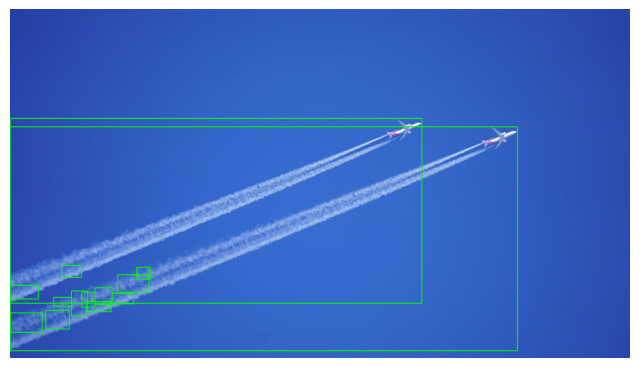

In [993]:
similar_regions = []
binary_mask = np.zeros(gray_image.shape, dtype=np.uint8) 

for i in range(len(moments_list)):
    for j in range(i + 1, len(moments_list)):
        similarity = np.linalg.norm(moments_list[i][1] - moments_list[j][1])
        if similarity < 0.1: 
            similar_regions.append((moments_list[i][0], moments_list[j][0]))

binary_mask = np.zeros(gray_image.shape, dtype=np.uint8) 
output_image = image.copy()

output1_image = image.copy()
for region_pair in similar_regions:
    for region in region_pair:
        min_row, min_col, max_row, max_col = region.bbox
        cv2.rectangle(output1_image, (min_col, min_row), (max_col, max_row), (0, 255, 0), 2)

plt.figure(figsize=(8, 8))
#plt.title("Similar Regions Detected")
plt.imshow(cv2.cvtColor(output1_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

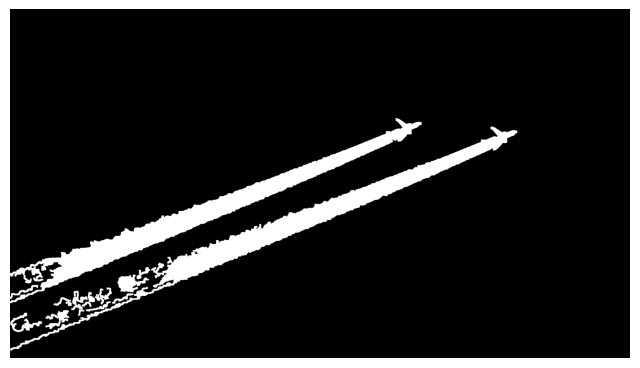

In [994]:
for region_pair in similar_regions:
    for region in region_pair:
        # Tạo một mặt nạ cho vùng cụ thể
        filled_region_mask = np.zeros_like(gray_image, dtype=np.uint8)

        # Sử dụng region.coords để đánh dấu vùng
        for coord in region.coords:
            filled_region_mask[coord[0], coord[1]] = 255

        # Tô đầy vùng bằng cách sử dụng contours
        contours, _ = cv2.findContours(filled_region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(binary_mask, contours, -1, 255, thickness=cv2.FILLED)

plt.figure(figsize=(8, 8))  # Tạo cửa sổ với kích thước 8x8
#plt.title("Binary Mask")
plt.imshow(binary_mask, cmap='gray')  # Hiển thị ảnh nhị phân
plt.axis('off')  # Tắt trục tọa độ
plt.show()

In [ ]:
binary_mask = (binary_mask > 0).astype(np.uint8)
ground_truth = (ground_truth > 0).astype(np.uint8)

TP = np.sum((binary_mask == 1) & (ground_truth == 1)) 
FP = np.sum((binary_mask == 1) & (ground_truth == 0)) 
FN = np.sum((binary_mask == 0) & (ground_truth == 1)) 

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_measure = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

In [ ]:
print(f"Sigma: {sigma}")
print(f"Iterations: {iterations}")
print(f"Kernel size: {kernel_size}")
print(f"Block Size: {block_size}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Measure: {f1_measure:.4f}")

Sigma: 1
Iterations: 1
Kernel size: 5
Block Size: 500
Precision: 0.8940
Recall: 0.8009
F1-Measure: 0.8449


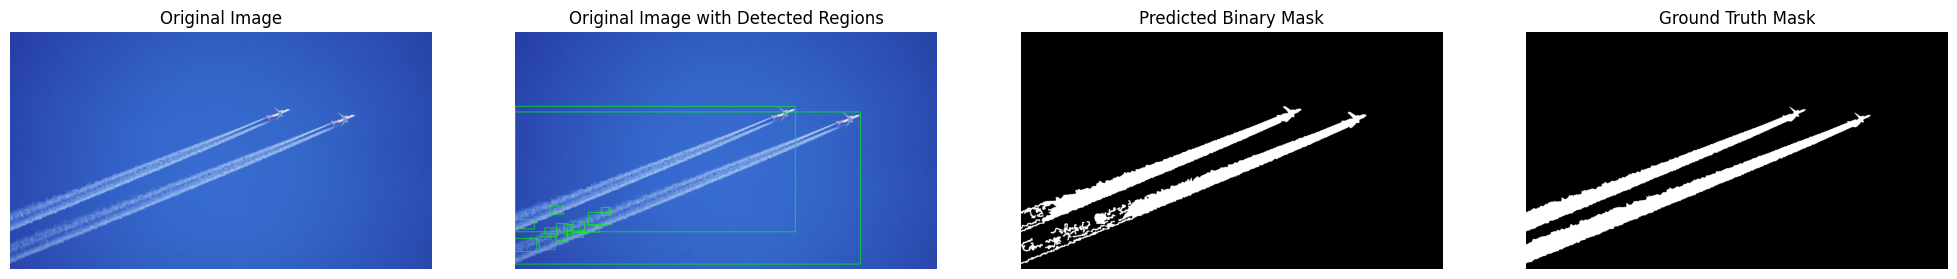

In [ ]:
plt.figure(figsize=(25, 25))

plt.subplot(1, 4, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Original Image with Detected Regions")
plt.imshow(cv2.cvtColor(output1_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Predicted Binary Mask")
plt.imshow(binary_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("Ground Truth Mask")
plt.imshow(ground_truth, cmap='gray')
plt.axis('off')

plt.show()